Before starting working on this Python lab, install the following library with this command


In [11]:
# pip install pgmpy

In [12]:
from IPython.display import Image
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Bayesian networks

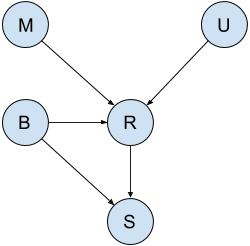

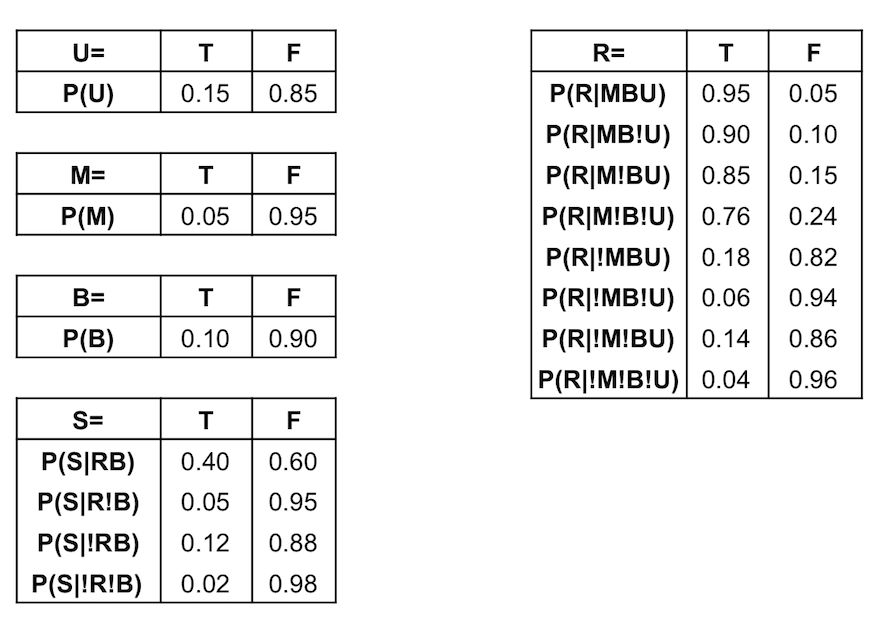

Create Bayesian network and corresponding conditional probabilities and check if model is correct.

In [13]:
model = BayesianModel([('M', 'R'), ('B', 'R'), ('B', 'S'), ('U', 'R'), ('R', 'S')])
cpd_u = TabularCPD(variable='U', variable_card=2, values=[[0.15], [0.85]], state_names={'U': ['T', 'F']})
cpd_m = TabularCPD(variable='M', variable_card=2, values=[[0.05], [0.95]], state_names={'M': ['T', 'F']})
cpd_b = TabularCPD(variable='B', variable_card=2, values=[[0.10], [0.90]], state_names={'B': ['T', 'F']})
cpd_r = TabularCPD(variable='R', variable_card=2,
                   values=[[0.95, 0.90, 0.85, 0.76, 0.18, 0.06, 0.14, 0.04],
                           [0.05, 0.10, 0.15, 0.24, 0.82, 0.94, 0.86, 0.96]],
                   evidence=['M', 'B', 'U'],
                   evidence_card=[2, 2, 2],
                   state_names={'R': ['T', 'F'],
                                'M': ['T', 'F'],
                                'B': ['T', 'F'],
                                'U': ['T', 'F']})
cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.40, 0.05, 0.12, 0.02],
                           [0.60, 0.95, 0.88, 0.98]],
                  evidence=['R', 'B'],
                  evidence_card=[2, 2],
                  state_names={'S': ['T', 'F'],
                               'R': ['T', 'F'],
                               'B': ['T', 'F']})

model.add_cpds(cpd_u, cpd_m, cpd_b, cpd_r, cpd_s)
model.check_model()


/opt/homebrew/lib/python3.10/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


True

Find proability of $P(R)$ and $P(R|M)$ using pgmpy. Check the output with your manual calculation.

In [14]:
infer = VariableElimination(model)
r_dist = infer.query(['R'])
print(r_dist)
r_m = infer.query(['R'], evidence={'M': 'T'})
print(r_m)


+------+----------+
| R    |   phi(R) |
+======+==========+
| R(T) |   0.0938 |
+------+----------+
| R(F) |   0.9062 |
+------+----------+
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(T) |   0.7869 |
+------+----------+
| R(F) |   0.2131 |
+------+----------+


Investigate at least two features in pgmpy that you find interesting, e.g., check dependencies between the variables, etc.

In [15]:
print(model.local_independencies(['U', 'M', 'B', 'R', 'S']))
print(infer.map_query(['R']))

(U ⟂ B, M)
(M ⟂ B, U)
(B ⟂ U, M)
(S ⟂ U, M | B, R)


Eliminating: M: 100%|██████████| 3/3 [00:00<00:00, 1805.04it/s]

{'R': 'F'}


## Markov random fields

### Image denoising with Ising model

Text(0.5, 1.0, 'True binary image')

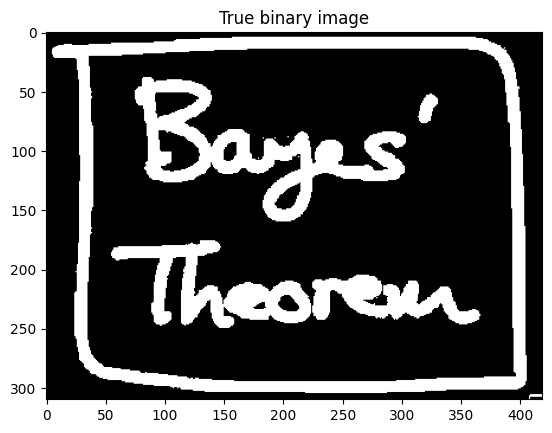

In [16]:
#load image data
data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

plt.figure()
plt.imshow(clean_img,cmap='Greys')
plt.title("True binary image")


310 419


Text(0.5, 1.0, 'observed noisy image')

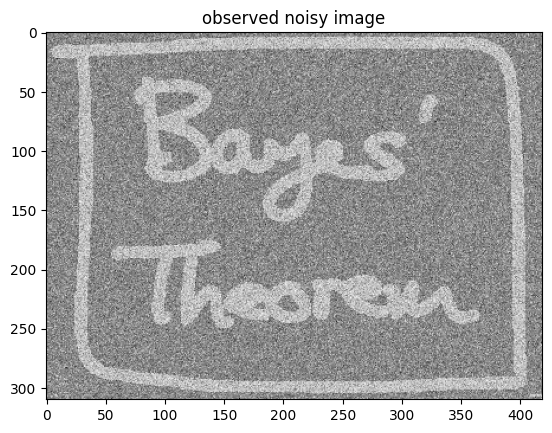

In [17]:
height,width = clean_img.shape
print(height,width)
sigma  = 1  #noise level
noisy_img = clean_img + sigma*np.random.randn(height, width)
plt.figure()
plt.imshow(noisy_img, cmap='Greys')
plt.title("observed noisy image")

Implement Ising model to denoise noisy image. Here, the objective is minimizing the following energy function using iterated conditional method.
$$ E(x,y) = h\sum_{i}x_{i} - \beta\sum_{i,j}x_{i}x_{j}-\eta\sum_{i}x_{i}y_{i} $$


iterated conditional method:

initialization: $x_{i}=y_{i}$ for all $i$

For $j = 1, . . . ,N$
  1. Evaluate total energy for states $x_{j} = +1$ and $x_{j} = −1$ keeping all other variables fixed.
      Set $x_{j}$ to state with lower energy.
  2. Repeat 1 until convergence or stopping criterion.
  
  
 Comapre denoised image with the original image.

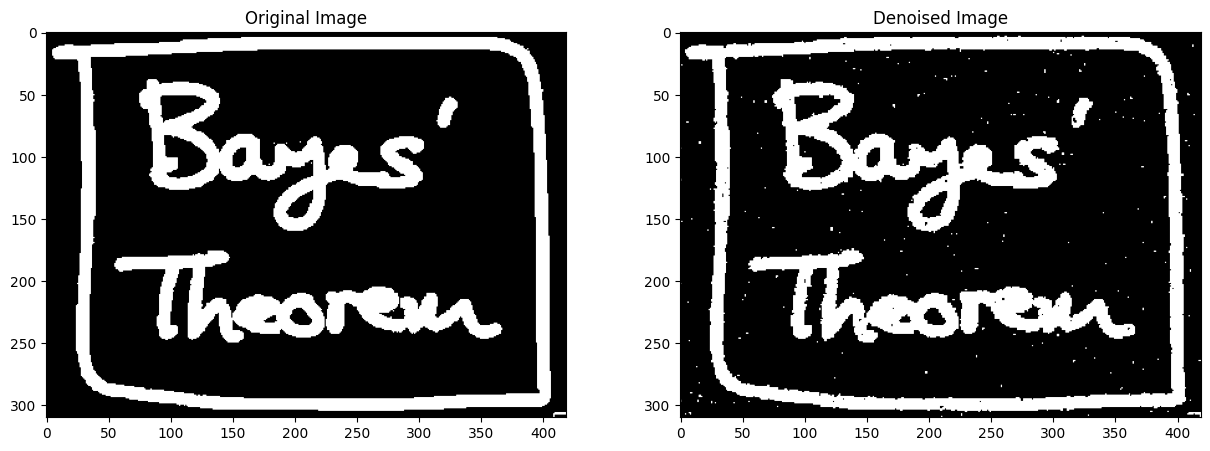

In [18]:
def neighbors(x, i, j):
    """
    Find neighboring indices
    """
    nx, ny = x.shape
    r, c = [], []
    if i > 0:
        r.append(i - 1)
        c.append(j)
    if j > 0:
        r.append(i)
        c.append(j - 1)
    if i < nx - 1:
        r.append(i + 1)
        c.append(j)
    if j < ny - 1:
        r.append(i)
        c.append(j + 1)
    return r, c

def neighbor_energy(x, i, j, beta):
    """
    Sum of energies in the neighborhood
    """
    rows, cols = neighbors(x, i, j)
    energy = 0.
    for row, col in zip(rows, cols):
        energy = energy + x[row, col]
    return x[i,j] * beta * energy

def E(x, y, h, beta, eta):
    total_energy = h * x.sum() - eta * (x * y).sum()
    total_energy = 0
    nx, ny = x.shape
    for i in range(nx):
        for j in range(ny):
            rows, cols = neighbors(x, i, j)
            neighbor_energy = 0.
            for row, col in zip(rows, cols):
                neighbor_energy = neighbor_energy + x[row, col] * x[i, j]
            total_energy = total_energy - beta * neighbor_energy - eta * x[i, j] * y[i, j]     
    return total_energy

def local_energy(x, y, i, j, h, beta, eta):
    rows, cols = neighbors(x, i, j)
    neigh_energy = neighbor_energy(x, i, j, beta)
    # Energy from neighbors in xy-clique
    neigh_xy_energy = 0.0
    for row, col in zip(rows, cols):
        neigh_energy += neighbor_energy(x, row, col, beta)
        neigh_xy_energy += eta * x[row, col] * y[row, col] 
    energy = h * x[i, j] - eta * x[i, j] * y[i, j] - neigh_energy - neigh_xy_energy
    return energy

def update_pixels(x, y):
    nx, ny = x.shape
    x = x.copy()
    for i in range(nx):
        for j in range(ny):
            x[i,j] = 1
            energy_plus = local_energy(x, y, i, j, h, beta, eta)
            x[i,j] = -1
            energy_minus = local_energy(x, y, i, j, h, beta, eta)
            if energy_plus <= energy_minus:
                x[i,j] = 1
            else:
                x[i,j] = -1          
    return x

def ising_learn(y):
    x = y.copy()
    while True:
        x = update_pixels(x, y)
        return x
    
h = 0 
beta = 1
eta = 2.1
y = noisy_img.copy()
x = ising_learn(y)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(clean_img, cmap='Greys')
plt.subplot(122)
plt.title('Denoised Image')
plt.imshow(x, cmap='Greys')
plt.show()

Try different noise levels and plot the normalized mean squared error (NMSE) vs noise level.
NMSE is defined as following
$$ NMSE = \frac{|D-G|^{2}}{|G|^2} $$
Here, $D$ is the denoised image and $G$ is the ground truth or clean image.

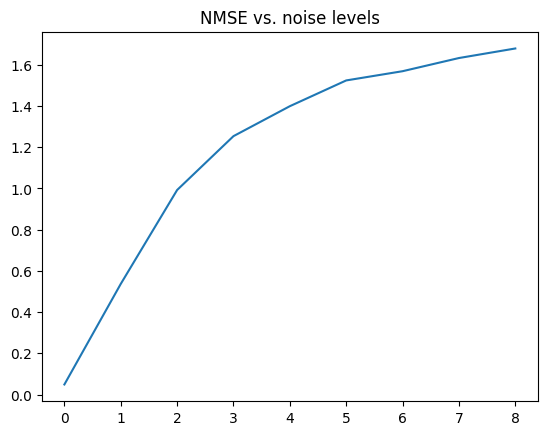

In [19]:
NMSE = lambda D: (((clean_img - D)**2).sum() / (clean_img**2).sum())**1
err = []
for sigma in range(0,10,1):
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    y = noisy_img.copy()
    x = ising_learn(y)
    err.append(NMSE(x))
   
plt.title('NMSE vs. noise levels')
plt.plot(err)
plt.show()

Try different parameters in the energy function, e.g., $ h, \beta, \eta$, and  plot the following figures.
1. NMSE vs $ h$
2. NMSE vs $ \beta$
3. NMSE vs $ \eta$

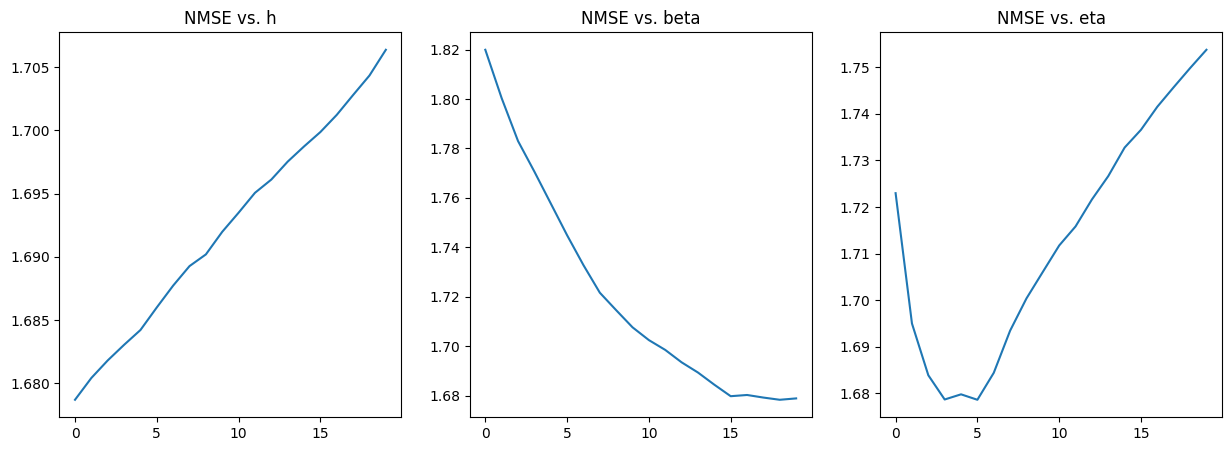

In [20]:
NMSE = lambda D: (((clean_img - D)**2).sum() / (clean_img**2).sum())**1

sigma = 1
itr = 10
H_factor = []
for h in np.arange(0,1,0.05):
    beta = 1
    eta = 2.1
    y = noisy_img.copy()
    x = ising_learn(y)
    H_factor.append(NMSE(x))
        
Beta = []        
for beta in np.arange(0,1,0.05):
    h = 0
    eta = 2.1
    y = noisy_img.copy()
    x = ising_learn(y)
    Beta.append(NMSE(x))
        
Eta = []
for eta in np.arange(0,10,0.5):
    h = 0
    beta = 1
    y = noisy_img.copy()
    x = ising_learn(y)
    Eta.append(NMSE(x))

# horizontal label is the number of points    
plt.figure(figsize=(15,5))
plt.subplot(131)      
plt.title('NMSE vs. h')
plt.plot(H_factor)
plt.subplot(132)
plt.title('NMSE vs. beta')
plt.plot(Beta)
plt.subplot(133)
plt.title('NMSE vs. eta')
plt.plot(Eta)
plt.show()